# Evaluating Past Returns

### More Machine Learning
### Kerry Back, JGSB, Rice University

<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/10-attribution.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Outline

1. Evaluating without benchmarking - Sharpe ratios and drawdowns
2. Naive benchmarking
3. Benchmarking - alphas and information ratios
4. Attribution analysis - alphas and betas and information ratios

### Data 

- Monthly FMAGX returns from Yahoo Finance (FMAGX = Fidelity Magellan)
- Market return from French's data library
- Fama-French factors and momentum from French's data library

## Monthly returns

In [1]:
import yfinance as yf

ticker = "FMAGX"
price = yf.download(ticker, start=1970)["Adj Close"]
price_monthly = price.resample("M").last()
price_monthly.index = price_monthly.index.to_period("M")
return_monthly = price_monthly.pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


## Monthly risk-free rates from French's data library

In [2]:
from pandas_datareader import DataReader as pdr
fama_french = pdr("F-F_Research_Data_5_Factors_2x3", "famafrench", start=1970)[0] / 100
rf = fama_french["RF"]

## Evaluating without benchmarking

### Sharpe ratio

In [3]:
import numpy as np

rprem = 12 * (return_monthly - rf).mean()
stdev = np.sqrt(12) * return_monthly.std()
sharpe = rprem / stdev

print(f"Annualized Sharpe ratio is {sharpe:.2%}")

Annualized Sharpe ratio is 46.21%


### Drawdowns

- A drawdown is how much you've lost since the previous peak value.
- It's another way to represent risk.
- We'll use the daily price data.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns
sns.set_style("whitegrid")
colors = sns.color_palette()

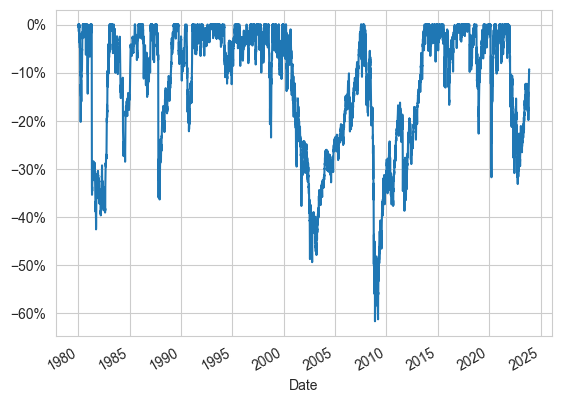

In [5]:
fig, ax = plt.subplots()
price_max = price.expanding().max()
drawdown = 100 * (price - price_max) / price_max
drawdown.plot(ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

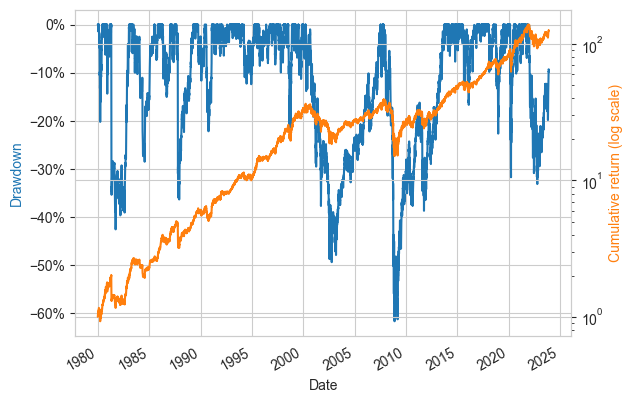

In [6]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.set_yscale("log")
drawdown.plot(ax=ax1)

cumulative_return = price / price.iloc[0]
cumulative_return.plot(ax=ax2, c=colors[1])

ax1.set_xlabel('Date')
ax1.set_ylabel('Drawdown', color=colors[0])
ax2.set_ylabel('Cumulative return (log scale)', color=colors[1])

ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

## Naive Benchmarking

- Did you beat the benchmark?
- Compute returns in excess of the benchmark and the mean excess return.
- How risky are these excess returns?
- The standard deviation of return in excess of the benchmark is called tracking error.
- Reward to risk ratio = mean excess return / tracking error
- Naive = "don't adjust for beta"

### Market return

In [7]:
mkt = fama_french["Mkt-RF"] + fama_french["RF"]

### Mean, risk (tracking error) and reward-to-risk



In [8]:
mean = 12 * (return_monthly - mkt).mean()
track_error = np.sqrt(12) * (return_monthly - mkt).std()
reward_to_risk = mean / stdev

print(f"annualized mean return in excess of market is {mean:.2%}")
print(f"annualized tracking error is {track_error:.2%}")
print(f"annualized reward-to-risk ratio is {reward_to_risk:.2%}")

annualized mean return in excess of market is 0.37%
annualized tracking error is 7.29%
annualized reward-to-risk ratio is 2.02%


## Benchmarking

### Alpha

- Run the regression
$$ r - r_f = \alpha + \beta (r_b-rf) + \varepsilon$$
- where $r_b=$ benchmark return
- Rearrange:
$$r - \bigg[\beta \bar{r}_b + (1-\beta)r_f\bigg] = \alpha + \varepsilon$$
- So, $\alpha + \varepsilon$ is the excess return over a beta-adjusted benchmark.  It is called the active return.
- The beta-adjusted benchmark $\beta \bar{r}_b + (1-\beta)r_f$ has the same beta as $r$.
- $\alpha$ is the mean active return.

### Alpha and mean-variance efficiency

- We can improve on a benchmark by adding some of another return $r$ if and only if its alpha relative to the benchmark is positive.
- We can improve by shorting $r$ if its alpha is negative.
- Cannot improve on benchmark $\,\Leftrightarrow \alpha = 0$

### Information ratio

- The risk of the active return is the risk of the regression residual $\varepsilon$
- Reward to risk ratio $\alpha / \text{std dev of} \; \varepsilon$ is called the **information ratio.**
- Information ratio is the most important statistic for evaluating performance relative to a benchmark.

### Code

- Use statsmodels ols function to run regressions in python.
- Define model and fit.
- Fitted object has .summary() method, .params attribute and others.  
- Residual standard deviation is square root of .mse_resid
- We'll use the market as the benchmark

In [9]:
import pandas as pd 
import statsmodels.formula.api as smf

df = pd.concat((return_monthly, mkt, rf), axis=1).dropna()
df.columns = ["ret", "mkt", "rf"]
df[["ret_rf", "mkt_rf"]] = df[["ret", "mkt"]].subtract(df.rf, axis=0)

result = smf.ols("ret_rf ~ mkt_rf", df).fit()

In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_rf   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     2892.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          5.26e-215
Time:                        13:54:10   Log-Likelihood:                 1287.2
No. Observations:                 524   AIC:                            -2570.
Df Residuals:                     522   BIC:                            -2562.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.001     -0.227      0.820      -0.002       0.002
mkt_rf         1.0765      0.020     53.774      0.000       1.037       1.116
==============================================================================
Omnibus:                      642.619   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118829.986
Skew:                          -5.621   Prob(JB):                         0.00
Kurtosis:                      75.912   Cond. No.                         22.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
alpha = 12 * result.params["Intercept"]
resid_stdev = np.sqrt(12 * result.mse_resid)
info_ratio = alpha / resid_stdev

print(f"The annualized information ratio is {info_ratio:.2%}")


The annualized information ratio is -3.48%


### Plotting

- Plot the compound returns $(1+r_1)(1+r_2) \cdots (r+r_n)$
- Plot the compounded beta-adjusted benchmark returns
- Plot the compounded active returns
- Gives a visual of whether returns were earned from the benchmark or from active return.

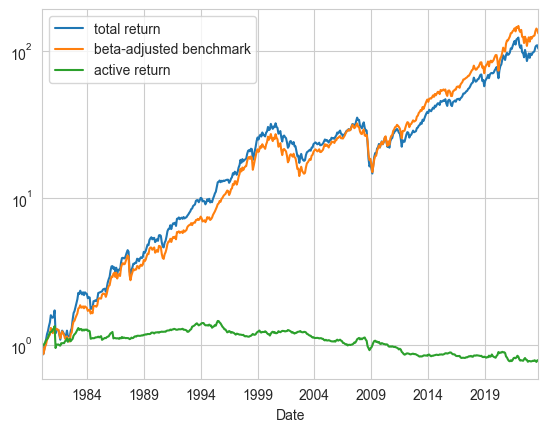

In [12]:
beta = result.params["mkt_rf"]
beta_adjusted_bmark = beta*df.mkt + (1-beta)*df.rf 
active = df.ret - beta_adjusted_bmark

(1+df.ret).cumprod().plot(label="total return", logy=True)
(1+beta_adjusted_bmark).cumprod().plot(label="beta-adjusted benchmark", logy=True)
(1+active).cumprod().plot(label="active return", logy=True)
plt.legend()
plt.show()

## Attribution Analysis

### Factors and attribution

- It is generally agreed that there are portfolio strategies ("factors" or "styles") that earn risk premia that are not explained by the CAPM.
  - Value, momentum, profitability, ...
- An institution evaluating a manager's results will look to see if any common factors are responsible for the results by running regressions on the benchmark and factors.
- In other words, we ask whether the returns can be attributed to common factors.


### Alphas and information ratios again

- For simplicity, consider a single factor or style with return $r_s$.  Suppose it is a long-minus-short return.
- We run the regression
$$r - r_f = \alpha + \beta_1 (r_b-r_f) + \beta_2 r_s + \varepsilon$$
- We can rearrange as
$$r - \bigg[\beta_1 r_b + (1-\beta_1)r_f + \beta_2 r_s\bigg] = \alpha + \varepsilon$$
- The return in square braces is a beta and factor adjusted benchmark.
- The alpha and the information ratio have the same meaning as before, except that now we are also adjusting for factor exposure.


### Data

- Fama-French factors
  - SMB = small minus big (size factor)
  - HML = high book-to-market minus low book-to-market (value factor)
  - CMA = conservative minus agressive (investment rate factor)
  - RMW = robust minus weak (profitability factor)
- Momentum
  - UMD = up minus down
- All from French's data library

In [13]:
fama_french.head(3)

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1970-01,-0.0810,0.0312,0.0313,-0.0172,0.0384,0.0060
1970-02,0.0513,-0.0276,0.0393,-0.0229,0.0276,0.0062
1970-03,-0.0106,-0.0241,0.0399,-0.0100,0.0429,0.0057


In [14]:
umd = pdr("F-F_Momentum_Factor", "famafrench", start=1970)[0]/100
umd.columns = ["UMD"]
umd.head(3)

,UMD
Date,
1970-01,0.0060
1970-02,0.0023
1970-03,-0.0036


In [15]:
data = pd.concat((fama_french, umd, df), axis=1).dropna()
result = smf.ols("ret_rf ~ mkt_rf + SMB + HML + RMW + CMA + UMD", data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_rf   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     502.5
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          4.68e-212
Time:                        13:54:11   Log-Likelihood:                 1298.6
No. Observations:                 524   AIC:                            -2583.
Df Residuals:                     517   BIC:                            -2553.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.048e-05      0.001     -0.096      0.924      -0.002       0.002
mkt_rf         1.0729      0.022     48.365      0.000       1.029       1.116
SMB           -0.0638      0.034     -1.860      0.063      -0.131       0.004
HML           -0.0509      0.041     -1.229      0.220      -0.132       0.030
RMW            0.0332      0.043      0.778      0.437      -0.051       0.117
CMA           -0.0943      0.061     -1.535      0.125      -0.215       0.026
UMD            0.0351      0.021      1.637      0.102      -0.007       0.077
==============================================================================
Omnibus:                      648.691   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124020.660
Skew:                          -5.708   Prob(JB):                         0.00
Kurtosis:                      77.498   Cond. No.                         78.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""